# Turbine test in MMC with wind direction change

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend',
                 '/ascldap/users/lcheung/wind_uq/amrwind-frontend/',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import numpy             as np
import math
import pandas as pd
import postproamrwindsample as ppsample
import time
import utm
import shutil

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

In [3]:
# Location of precursor run with boundary data
precursordir  = '/gpfs/lcheung/AWAKEN/Benchmark1/Phase2/wdirtest_01'
precursorsetup= precursordir+'/abl_MMC.inp'

# Location of farm run dir
farmrundir       = './turbtest_MMC_WDirChange2'
outputfile       = 'turbtest.inp'
noturboutputfile = 'turbtest_noturb.inp'

verbose          = True
cwd              = os.getcwd()

# Go to the run directory
if os.path.exists(farmrundir):
    shutil.rmtree(farmrundir)

os.makedirs(farmrundir, exist_ok = True)
os.chdir(farmrundir)

# Load the starting point
case.loadAMRWindInput(precursorsetup)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


OrderedDict()

In [4]:
tstart = 0
tstop  = tstart+360

In [5]:
# Set the time constants
case.setAMRWindInput('time.stop_time', tstop)
case.setAMRWindInput('time.fixed_dt',  0.1)
case.setAMRWindInput('time.max_step',  -1)

In [6]:
# set verbosity
case.setAMRWindInput('incflo.verbose', 0)

In [7]:
# Set the restart point
chkdir = precursordir+'/chk00000/'
case.setAMRWindInput('restart_file', os.path.realpath(chkdir))

In [8]:
# Set the boundary input file parameters
ablstatfile = precursordir+'/post_processing/abl_statistics00000.nc'
#tavg        =  [tstart, tstop]
#forcingdict = {'ablstatfile':ablstatfile, 'tavg':tavg}
forcingdict = {'ablstatfile':ablstatfile, 'tendencyforcing_file':'./tendencyforcing.nc'}
inflowplanes= ['xlo', 'ylo',] #[ 'xhi']
bndryfiles  = precursordir+'/bndry_file'

In [9]:
case.boundaryplane_restart(bndryfiles=bndryfiles, 
                           forcingdict=forcingdict, 
                           inflowplanes=inflowplanes, 
                           checkpointdir=chkdir,
                           autoset_BodyForcing=False,
                           autoset_MMCForcing=False,
                           autoset_MMCTendencyForcing=True,
                           verbose=True)

SET ABL_bndry_io_mode = '1'
SET ABL_bndry_file = '/gpfs/lcheung/AWAKEN/Benchmark1/Phase2/wdirtest_01/bndry_file'
SET ABL_bndry_planes = ['xlo', 'ylo']
SET is_periodicx = False
SET is_periodicy = False
SET xlo_type = 'mass_inflow'
SET xlo_density = 1.225
SET xlo_temperature = 0.0
SET xlo_tke = 0.0
SET ylo_type = 'mass_inflow'
SET ylo_density = 1.225
SET ylo_temperature = 0.0
SET ylo_tke = 0.0
SET xhi_type = 'pressure_outflow'
SET xhi_density = None
SET xhi_temperature = None
SET xhi_tke = None
SET yhi_type = 'pressure_outflow'
SET yhi_density = None
SET yhi_temperature = None
SET yhi_tke = None
SET ABLForcing = False
Wrote ./tendencyforcing.nc
SET ABL_tendency_forcing = True
SET ABL_mesoscale_forcing = './tendencyforcing.nc'
SET ABLMesoForcingMom = True
SET ABL_initial_condition_input_file = 'None'
SET ABLMeanBoussinesq = True
SET wall_shear_stress_type = 'local'
SET checkpoint_start = 0


## Add the turbine

In [10]:
# Add the turbine specifications flag
## Note that the options field can have things like:
##    ADparam_TwrAero:False ADparam_TwrShadow:0 FSTparam_TMax:181234.0


OFoptions=("ADparam_TwrAero:True ADparam_TwrShadow:1 "
           "FSTparam_DT_Out:0.02 "
           "FSTparam_TStart:0.0 "
           "EDparam_RotSpeed:6.00 "
           "EDparam_YawDOF:True "
           "SDparam_YawNeut:0.0 "
           "SDparam_YCMode:5 "
           "SDparam_TYCOn:0.0 "
           "DISCONparam_Y_ControlMode:1 "
           "DISCONparam_Y_ErrThresh:'4.0 4.0' "
           "AMRparam_Actuator_epsilon:[2;2;2] "
           "AMRparam_Actuator_epsilon_tower:[2;2;2] "
           "AMRparam_Actuator_openfast_stop_time:1200.0 "
          )

## To specify changes to the OpenFAST model
turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
T0,     0, 0, NREL 2.8-127 ADM AWAKEN, 270.0, , {OFoptions}
""".format(OFoptions=OFoptions)
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)

In [11]:
case.setAMRWindInput('turbines_createnewdomain', False)
case.setAMRWindInput('turbines_deleteprev', True)

case.turbines_createAllTurbines()

docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN to T0_OpenFAST_NREL2p8-127_AWAKEN
T0_OpenFAST_NREL2p8-127_AWAKEN/NREL-2p8-127.fst
Setting Actuator_epsilon to [2, 2, 2]
Setting Actuator_epsilon_tower to [2, 2, 2]
Setting Actuator_openfast_stop_time to 1200.0
OrderedDict([('DT_Out', 0.02), ('TStart', 0.0)])
OrderedDict([('TwrAero', 'True'), ('TwrShadow', 1)])
OrderedDict([('YawNeut', 0.0), ('YCMode', 5), ('TYCOn', 0.0)])
OrderedDict([('RotSpeed', 6.0), ('YawDOF', 'True')])
OrderedDict([('Y_ControlMode', 1), ('Y_ErrThresh', '4.0 4.0')])


      0.02 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
       0.0 TStart - Time to begin tabular output (s) [EDITED]
         1 TwrShadow - Calculate tower influence on wind based on downstream tower shadow (switch) {0=none 1=Powles model 2=Eames model} [EDITED]
      True TwrAero - Calculate tower aerodynamic loads? (flag) [EDITED]
         5 YCMode - Yaw control mode {0: none 3: user-defined from routine UserYawCont 4: user-defined from Simulink/Labview 5: user-defined from Bladed-style DLL} (switch) [EDITED]
       0.0 TYCOn - Time to enable active yaw control (s) [unused when YCMode=0] [EDITED]
       0.0 YawNeut - Neutral yaw position--yaw spring force is zero at this yaw (degrees) [EDITED]
      True YawDOF - Yaw DOF (flag) [EDITED]
       6.0 RotSpeed - Initial or fixed rotor speed (rpm) [EDITED]
1 ! Y_ControlMode   - Yaw control mode {0: no yaw control, 1: yaw rate control, 2: yaw-by-IPC} [EDITED]
4.0 4.0 ! Y_ErrThresh    - Yaw error threshold/deadbands. T

## Add turbine refinement

In [12]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,     10,       10,         3,       2,     2,     center:farm
1,     2.5,      2.5,        2.5,     1.2,   1.2,   center:farm
2,     1,        1,          0.75,    0.8,   0.8,  
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)

In [13]:
case.refine_createAllZones()
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxtagging'].getitemlist())

['Farm_level_0_zone', 'Farm_level_1_zone', 'T0_level_2_zone']


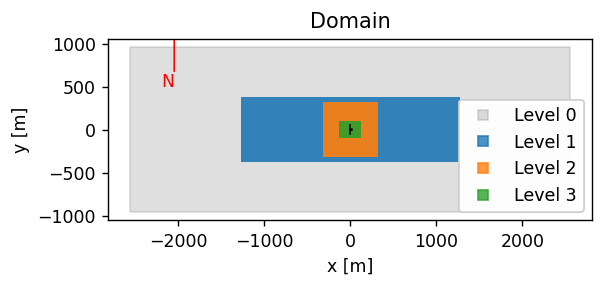

In [14]:
# Plot the domain
fig, ax2 = plt.subplots(figsize=(5,5), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.plotDomain(ax=ax2)

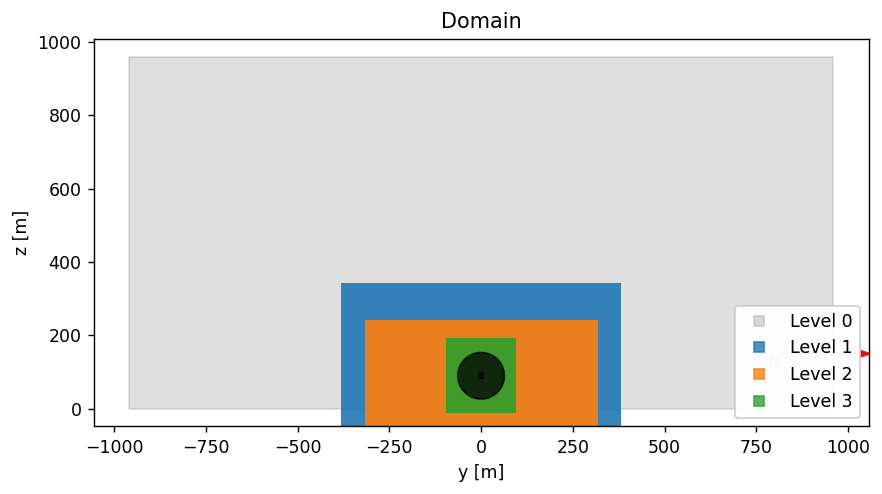

In [15]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,6), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'YZ'
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.plotDomain(ax=ax)

In [16]:
case.estimateMeshSize()

Refinement Farm_level_0_zone: level 1: 983223 cells
Refinement Farm_level_1_zone: level 2: 983223 cells
Refinement T0_level_2_zone: level 3: 629263 cells
ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0      1179648             20.0 x 20.0 x 20.0
       1       983223             10.0 x 10.0 x 10.0
       2       983223                5.0 x 5.0 x 5.0
       3       629263                2.5 x 2.5 x 2.5
  TOTAL:      3775357


### Create sampling planes

In [17]:
samplingcsv="""
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name, type, upstream, downstream, lateral, below, above, n1, n2, options
#cl1, centerline, 1,  0, none, none,  none,  11, 11, none
#rp1, rotorplane, 2,  0, none, none,  none,  11, 11, none
#sw1, streamwise, 2,  1, 1, 0.5,  0.5,  11, 11, usedx:0.25 noffsets:1
hh,  hubheight,2560,2560,960, 0,  none,  11, 11, usedx:10 units:meter center:farm orientation:x wholedomain:1
"""
case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', True)

In [18]:
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['Farm_hh']


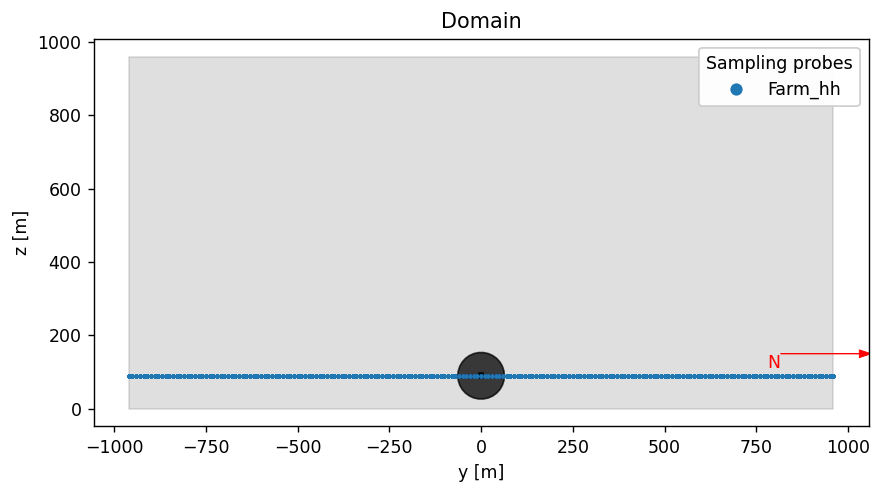

In [19]:
# Plot the domain
fig, ax = plt.subplots(figsize=(8,6), facecolor='w', dpi=125)
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.plotDomain(ax=ax)

In [20]:
print(case.writeAMRWindInput(outputfile))

# --- Simulation time control parameters ---
time.stop_time                           = 360.0               # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.1                 # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 10000               
time.checkpoint_start                    = 0                   
incflo.physics                           = ABL Actuator        # List of physics models to include in simulation.
incflo.verbose                           = 0                   
io.check_file                            = chk                 
io.restart_file                          = /gpfs/lcheung/AWAKEN/Benchmark1/Phase2/wdirtest_01/chk00000
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = OneEqKsgsM84 